In [1]:
with open("../Figures/COVID/AA_sequence_combined.txt") as f:
    sarscov2_combined = f.read().strip()

In [2]:
from pepdata import iedb

In [3]:
df_mhc = iedb.mhc.load_dataframe()

In [4]:
df_tcell = iedb.tcell.load_dataframe()

                      Reference                                     \
                      Assay IRI                      Reference IRI   
0  http://www.iedb.org/assay/29  http://www.iedb.org/reference/274   
1  http://www.iedb.org/assay/37  http://www.iedb.org/reference/281   
2  http://www.iedb.org/assay/42  http://www.iedb.org/reference/283   
3  http://www.iedb.org/assay/43  http://www.iedb.org/reference/283   
4  http://www.iedb.org/assay/47  http://www.iedb.org/reference/275   

                                                                              \
         Type   PubMed ID                                            Authors   
0  Literature  15448372.0  Yi-Hsiang Huang; Mi-Hua Tao; Cheng-po Hu; Wan-...   
1  Literature   7684468.0  V J La Posta; D D Auperin; R Kamin-Lewis; G A ...   
2  Literature  15634878.0    Evan R Jellison; Sung-Kwon Kim; Raymond M Welsh   
3  Literature  15634878.0    Evan R Jellison; Sung-Kwon Kim; Raymond M Welsh   
4  Literature  15519708.0  Ol

In [15]:
mhc_organisms = set(df_mhc["Epitope"]["Organism Name"].unique())

In [16]:
tcell_organisms = set(df_tcell["Epitope"]["Organism Name"].unique())

In [29]:
for o in mhc_organisms:
    if type(o) is str and "SARS" in o:
        print(o)
    if type(o) is str and "respiratory syndrome" in o.lower().replace("-", " "):
        print(">", o)

SARS coronavirus Tor2
Bat SARS CoV Rp3/2004
SARS-related coronavirus
SARS coronavirus Urbani
> Middle East respiratory syndrome-related coronavirus
> Porcine reproductive and respiratory syndrome virus
SARS coronavirus TJF
SARS coronavirus
SARS coronavirus BJ01


In [30]:
for o in tcell_organisms:
    if type(o) is str and "SARS" in o:
        print(o)
    if type(o) is str and "respiratory syndrome" in o.lower().replace("-", " "):
        print(">", o)

SARS coronavirus Tor2
SARS coronavirus Frankfurt 1
SARS coronavirus Urbani
> Middle East respiratory syndrome-related coronavirus
> Porcine reproductive and respiratory syndrome virus
> Porcine reproductive and respiratory syndrome virus HuN4
SARS coronavirus TJF
> Porcine reproductive and respiratory syndrome virus HuN4-F112
SARS coronavirus
SARS coronavirus BJ01


In [32]:
sars_organisms = { 
    "SARS-related coronavirus",
    "SARS coronavirus Urbani",
    "SARS coronavirus Tor2",
    "SARS coronavirus Frankfurt 1",
    "SARS coronavirus TJF",
    "SARS coronavirus",
    "SARS coronavirus BJ01",
}

In [35]:
df_tcell_sars = df_tcell[df_tcell["Epitope"]["Organism Name"].isin(sars_organisms)];
len(df_tcell_sars)

1440

In [36]:
df_mhc_sars = df_mhc[df_mhc["Epitope"]["Organism Name"].isin(sars_organisms)];
len(df_mhc_sars)

13432

In [37]:
sars2_kmers = set([])
for k in {8,9,10,11,12,13,14,15,16,17,18,19,20,21}:
    for i in range(len(sarscov2_combined) - k + 1):
        sars2_kmers.add(sarscov2_combined[i:i+k])

In [38]:
len(sars2_kmers)

135625

In [41]:
df_tcell_sars_in_sars2 = df_tcell_sars[df_tcell_sars["Epitope"]["Description"].isin(sars2_kmers)];
len(df_tcell_sars_in_sars2)

339

In [42]:
df_mhc_sars_in_sars2 = df_mhc_sars[df_mhc_sars["Epitope"]["Description"].isin(sars2_kmers)];
len(df_mhc_sars_in_sars2)

5068

In [43]:
df_mhc_sars_in_sars2.to_csv("mhc-sars2.csv", index=False)

In [44]:
df_tcell_sars_in_sars2.to_csv("tcell-sars2.csv", index=False)

In [46]:
df_mhc_sars_in_sars2["Assay"]["Method/Technique"].value_counts()

purified MHC/competitive/radioactivity    3783
purified MHC/direct/fluorescence          1095
purified MHC                                57
cellular MHC/direct/fluorescence            54
purified MHC/direct/radioactivity           51
cellular MHC/competitive/fluorescence       19
purified MHC/competitive/fluorescence        7
x-ray crystallography                        2
Name: Method/Technique, dtype: int64

In [47]:
df_tcell_sars_in_sars2["Assay"]["Method/Technique"].value_counts()

ELISPOT                   164
ELISA                      49
ICS                        38
3H-thymidine               35
multimer/tetramer          16
51 chromium                15
in vivo assay               9
in vitro assay              8
in vivo skin test           2
biological activity         2
intracellular staining      1
Name: Method/Technique, dtype: int64

In [83]:
df_mhc_sars_in_sars2_radio = df_mhc_sars_in_sars2[df_mhc_sars_in_sars2["Assay"]["Method/Technique"] == "purified MHC/competitive/radioactivity"]

peptides = df_mhc_sars_in_sars2_radio[("Epitope", "Description")];
affs_radio = df_mhc_sars_in_sars2_radio[("Assay", "Quantitative measurement")]
alleles = df_mhc_sars_in_sars2_radio["MHC"]["Allele Name"]

from collections import defaultdict

pmhc_to_affinities = defaultdict(list)
for nm, a, p in sorted(zip(affs_radio, alleles, peptides, )):
    pmhc_to_affinities[(a,p)].append(nm)

pmhc_to_aff = {pmhc: np.exp(np.median(np.log(affs))) for (pmhc,affs) in pmhc_to_affinities.items()}

with open("mhc_sars2_purified_competitive_radioactivity.csv", "w") as f:
    f.write("allele,peptide,affinity\n")
    for (a,p), nm in pmhc_to_aff.items():
        f.write("%s,%s,%0.2f\n" % (a, p, nm))
    print("Wrote %d items" % len(pmhc_to_aff))
    

df_mhc_sars_in_sars2_fluorescence = df_mhc_sars_in_sars2[
df_mhc_sars_in_sars2["Assay"]["Method/Technique"] == "purified MHC/direct/fluorescence"]

peptides = df_mhc_sars_in_sars2_radio[("Epitope", "Description")];
affs_radio = df_mhc_sars_in_sars2_radio[("Assay", "Quantitative measurement")]
alleles = df_mhc_sars_in_sars2_radio["MHC"]["Allele Name"]

from collections import defaultdict

pmhc_to_affinities = defaultdict(list)
for nm, a, p in sorted(zip(affs_radio, alleles, peptides, )):
    pmhc_to_affinities[(a,p)].append(nm)

pmhc_to_aff = {pmhc: np.exp(np.median(np.log(affs))) for (pmhc,affs) in pmhc_to_affinities.items()}

with open("mhc_sars2_purified_competitive_radioactivity.csv", "w") as f:
    f.write("allele,peptide,affinity\n")
    for (a,p), nm in pmhc_to_aff.items():
        f.write("%s,%s,%0.2f\n" % (a, p, nm))
    print("Wrote %d items" % len(pmhc_to_aff))
    

HLA-A*29:02	ATVAYFNMVY	0.01nM
HLA-A*23:01	HFISNSWLM	0.02nM
HLA-DRB1*01:01	MPNMLRIMASLVLAR	0.09nM
HLA-A*29:02	VMYMGTLSY	0.09nM
HLA-A*02:02	VLAWLYAAV	0.10nM
HLA-A*02:02	FLGRYMSAL	0.10nM
HLA-A*11:01	RMYIFFASFY	0.11nM
HLA-A*02:02	FLLPSLATV	0.13nM
HLA-A*02:06	MMISAGFSL	0.14nM
HLA-A*31:01	KVKYLYFIK	0.14nM
HLA-A*02:01	ALWEIQQVV	0.15nM
HLA-A*02:02	MMISAGFSL	0.15nM
HLA-A*30:02	FMGRIRSVY	0.16nM
HLA-A*31:01	QTMLFTMLR	0.16nM
HLA-A*24:02	HFISNSWLM	0.17nM
HLA-A*03:01	HLYLQYIRK	0.17nM
HLA-A*02:02	YTMADLVYA	0.18nM
HLA-A*02:02	TMADLVYAL	0.18nM
HLA-A*02:03	TLACFVLAA	0.19nM
HLA-A*02:03	FLLPSLATV	0.20nM
HLA-A*02:02	ILHCANFNV	0.21nM
HLA-A*11:01	TSFGPLVRK	0.21nM
Patr-B*13:01	MPASWVMRIM	0.21nM
HLA-A*02:01	MMISAGFSL	0.22nM
HLA-A*29:02	HFAIGLALYY	0.23nM
HLA-A*02:01	FLAFVVFLL	0.24nM
HLA-A*02:02	TLGVYDYLV	0.25nM
HLA-B*54:01	MPNMLRIMA	0.26nM
HLA-A*02:06	YTMADLVYA	0.26nM
HLA-DRB1*01:01	LNTLTLAVPYNMRVI	0.27nM
HLA-A*02:06	YLDAYNMMI	0.28nM
HLA-A*02:03	VVFLHVTYV	0.28nM
HLA-A*02:02	YLNTLTLAV	0.29nM
HLA-A*02:02	HLVDFQVT

HLA-B*40:02	VENPDILRV	1270.00nM
HLA-DRB1*01:01	VANYQKVGMQKYSTL	1270.00nM
HLA-A*02:03	LAFVVFLLV	1271.50nM
HLA-A*26:01	VFSAVGNICY	1280.00nM
HLA-A*30:02	SFNPETNIL	1280.00nM
HLA-B*45:01	RELHLSWEVG	1280.00nM
HLA-A*29:02	LPSLATVAY	1290.00nM
HLA-A*68:02	AIMTRCLAV	1300.50nM
HLA-A*68:02	NMLRIMASL	1311.50nM
HLA-A*03:01	GVAPGTAVLR	1320.00nM
HLA-A*11:01	GLVASIKNFK	1320.00nM
HLA-A*11:01	YLALYNKYK	1320.00nM
HLA-A*31:01	ATVVIGTSK	1320.00nM
HLA-A*33:01	SQASSRSSSR	1320.00nM
HLA-B*40:02	VEAVMYMGT	1320.00nM
HLA-B*53:01	NPAWRKAVF	1320.00nM
HLA-A*30:02	EYPIIGDEL	1330.00nM
HLA-A*68:01	KQIRSAAKK	1330.00nM
HLA-A*68:01	LLFVVEVVDK	1330.00nM
HLA-B*51:01	IPRRNVATL	1330.00nM
HLA-A*11:01	GLFCLLNRY	1340.00nM
HLA-A*29:02	DSSQGSEYDY	1350.00nM
HLA-A*30:02	EYADVFHLYL	1350.00nM
HLA-A*68:01	TQLYLGGMSY	1350.00nM
HLA-A*26:01	YYPSARIVY	1370.00nM
HLA-A*31:01	SVVNARLRAK	1370.00nM
HLA-A*68:01	GMSYYCKSHK	1370.00nM
HLA-A*68:01	KMQRMLLEK	1380.00nM
HLA-B*07:02	GPLVRKIFV	1380.00nM
HLA-A*68:02	LQLGFSTGV	1387.50nM
HLA-B*45:01	REVLSDRE

In [84]:
alleles.value_counts()

HLA-DRB1*01:01    241
HLA-A*01:01       171
HLA-A*23:01       171
HLA-A*30:02       171
HLA-A*26:01       171
HLA-A*29:02       171
HLA-A*24:02       171
HLA-A*02:03       170
HLA-A*02:01       170
HLA-A*02:02       170
HLA-A*02:06       170
HLA-A*03:01       165
HLA-A*68:01       165
HLA-A*31:01       165
HLA-A*11:01       165
HLA-A*33:01       165
HLA-A*68:02       155
HLA-B*18:01        88
HLA-B*44:02        88
HLA-B*40:01        88
HLA-B*45:01        88
HLA-B*44:03        88
HLA-B*40:02        88
HLA-B*07:02        47
HLA-B*51:01        47
HLA-B*54:01        47
HLA-B*35:01        47
HLA-B*53:01        47
Patr-B*01:01       24
Patr-A*01:01       14
Patr-B*13:01       12
Patr-B*24:01       12
Patr-A*09:01       11
Patr-A*07:01       11
Mamu-B*001:01       9
Name: Allele Name, dtype: int64

In [85]:
df_mhc_sars_in_sars2_radio["Assay"]["Quantitative measurement"]

14341       0.448
14342       3.680
14417     435.000
14434       2.320
14507       5.840
           ...   
198271      1.600
198272      0.610
198273      2.000
198274      4.600
198275      1.500
Name: Quantitative measurement, Length: 3783, dtype: float64

In [73]:
import seaborn

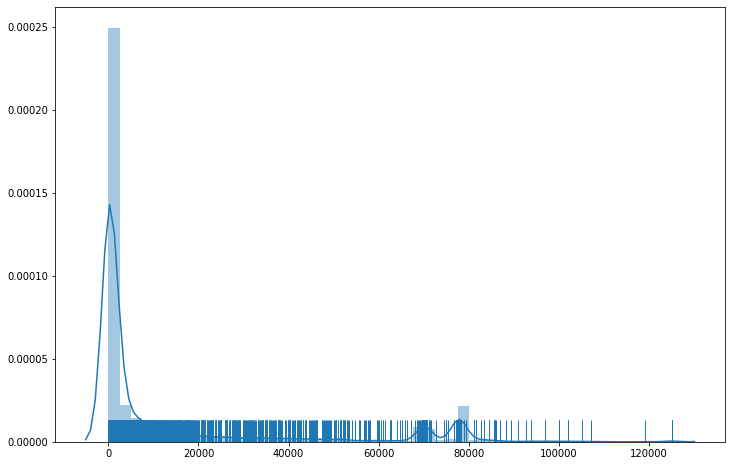

In [80]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
seaborn.distplot(list(pmhc_to_aff.values()), rug=True)

In [82]:
(np.array(list(pmhc_to_aff.values())) > 10**4).mean()

0.2588200415060777

FileNotFoundError: [Errno 2] No such file or directory: 'mhc_sars2_radio.csv'